<a href="https://colab.research.google.com/github/Houssam-Al-Deen/VIPP301A_Codes/blob/main/Dataset_from_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_excel("/content/LSDS-5YDM.xlsx")
print(df.shape)
df.head()


(6726, 24)


,metastasis,age,menopause,TNEG,ER,PR,P53,HER2,stage,node_status,...,grade,invasive,surgical_margins,surgery,breast_chest_radi,nodal_radi,chemo,antihormone,HER2_Inhib,neo
0,NO,three,POST,NO,POSITIVE,POSITIVE,NEGATIVE,NEGATIVE,one,NEGATIVE,...,two,YES,NO RESIDUAL TUMOR,CONSERVATION,YES,NO,NO,YES,NO,NO
1,NO,two,POST,NO,POSITIVE,POSITIVE,NEGATIVE,NEGATIVE,three,POSITIVE,...,one,YES,NO RESIDUAL TUMOR,CONSERVATION,NO,NO,YES,NO,NO,NO
2,NO,one,PRE,NO,POSITIVE,POSITIVE,NEGATIVE,NEGATIVE,one,POSITIVE,...,one,YES,NO RESIDUAL TUMOR,CONSERVATION,YES,NO,NO,NO,NO,NO
3,NO,three,POST,NO,POSITIVE,POSITIVE,NEGATIVE,NEGATIVE,one,NEGATIVE,...,one,YES,NO RESIDUAL TUMOR,CONSERVATION,NO,NO,NO,YES,NO,NO
4,NO,three,POST,NO,POSITIVE,POSITIVE,NEGATIVE,NEGATIVE,one,NEGATIVE,...,two,YES,NO RESIDUAL TUMOR,CONSERVATION,YES,NO,NO,YES,NO,NO


📦 Loading: LSDS-5YDM.xlsx
🧾 Using sheet: LSDS-5YDM
Original shape: (6726, 24)
After encoding:
  X shape: (6726, 23)
  dtypes: [dtype('int8')]

✅ NA-aware: Missing imputed with median; NA kept as distinct sentinel (-999).
✅ Imputed : Missing and NA BOTH imputed with median (no distinction).

📘 AUC (Area Under ROC) = ranking quality: 1.0 = perfect, 0.5 = random.
Below is a per-model comparison using the SAME train/test split for both strategies.



,Model,AUC_NAaware,AUC_Imputed,ΔAUC (Imputed - NA)
0,LogReg,0.799839,0.799839,0.0
1,RandomForest,0.770112,0.770112,0.0
2,XGBoost,0.710469,0.710469,0.0
3,KNN,0.670499,0.670499,0.0
4,DecisionTree,0.568185,0.568185,0.0



📊 Full metric comparison (same split)


,Model,Prec_NAaware,Prec_Imputed,Rec_NAaware,Rec_Imputed,F1_NAaware,F1_Imputed
0,LogReg,0.196,0.196,0.701,0.701,0.306,0.306
1,RandomForest,0.250,0.250,0.103,0.103,0.146,0.146
2,XGBoost,0.202,0.202,0.346,0.346,0.255,0.255
3,KNN,0.435,0.435,0.093,0.093,0.154,0.154
4,DecisionTree,0.217,0.217,0.243,0.243,0.229,0.229



📈 Accuracy comparison (same split)


,Model,Acc_NAaware,Acc_Imputed,ΔAccuracy (Imputed - NA)
0,LogReg,0.747,0.747,0.0
1,RandomForest,0.904,0.904,0.0
2,XGBoost,0.840,0.840,0.0
3,KNN,0.918,0.918,0.0
4,DecisionTree,0.870,0.870,0.0


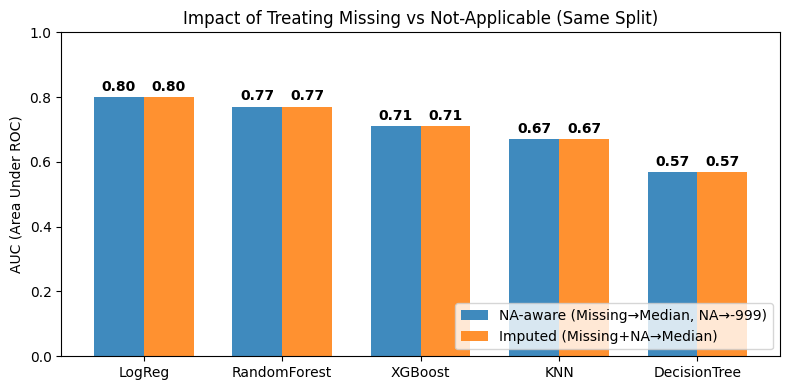


🧩 Summary:
• NA-aware keeps a visible NA signal (-999) while imputing true missing with median.
• Imputed removes the distinction and imputes both missing and NA with median.
• On average across models, ΔAUC ≈ +0.000 (Imputed - NA-aware).
• Best AUC (Imputed) model here: LogReg with AUC=0.800.
• If Recall is low, consider threshold tuning, class_weight='balanced', or SMOTE.


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Breast Cancer Metastasis — NA-aware vs Imputed on LSDS-5YDM

Same behavior / output style as your original script:
- AUC comparison for NA-aware vs Imputed
- Precision / Recall / F1 comparison
- Accuracy comparison
- Grouped bar chart
- Text summary
"""

import re, warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

try:
    from xgboost import XGBClassifier
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False

# =========================
# Configuration (ADAPTED)
# =========================
# If the script and Excel file are in the same folder, this is enough:
DATA_PATH     = "LSDS-5YDM.xlsx"      # <--- change if needed
TARGET_COL    = "metastasis"          # <--- target column
TEST_SIZE     = 0.2
RANDOM_STATE  = 42

# Your file has no *_coded columns, so:
KEEP_CODED_ONLY = False

# We keep all clinical / treatment columns as features:
DROP_SOFT_LEAKAGE = False

# NA handling settings
NA_TOKENS   = {-999, "-999", "NA", "N/A", "Not applicable",
               "not applicable", "na", "Na"}
NA_SENTINEL = -999  # sentinel to keep in NA-aware for NA-flagged entries

# =========================
# Loading
# =========================
def read_any(path):
    ext = str(path).split(".")[-1].lower()
    if ext in ("xlsx", "xls"):
        sheets = pd.read_excel(path, sheet_name=None)
        sheet_name = next(iter(sheets))
        print("📦 Loading:", path)
        print("🧾 Using sheet:", sheet_name)
        df = sheets[sheet_name]
    elif ext in ("csv",):
        print("📦 Loading:", path)
        df = pd.read_csv(path)
    else:  # TSV or generic delimited
        print("📦 Loading:", path)
        df = pd.read_csv(path, sep="\t")
    df.columns = df.columns.astype(str).str.strip()
    return df

def keep_coded_plus_target(df, target):
    if target not in df.columns:
        raise KeyError(f"Target '{target}' not found in columns.")
    cols = [c for c in df.columns if c.endswith("_coded")] + [target]
    cols = list(dict.fromkeys(cols))
    return df[cols]

# =========================
# Optional "soft leakage" drop (kept for completeness)
# =========================
def leakage_regex_rules():
    return [
        r"\bmetast", r"\brecurr", r"follow\s*up", r"\bsurvival\b", r"\bdeath\b",
        r"date.*(diagnosis|recurr|metast|follow)",

        r"\bcT_coded\b", r"\bcN_coded\b", r"\bcM_coded\b", r"\bClinical Stage_coded\b",

        r"mammogram.*_coded$", r"ultrasound.*_coded$", r"mri.*_coded$",
        r"number of masses.*_coded$", r"size of mass.*_coded$",
        r"imaging for axilla.*_coded$", r"axilla status.*_coded$",
        r"palpable aln.*_coded$", r"chest involvement.*_coded$",
        r"skin involvement.*_coded$", r"inflammatory.*_coded$",

        r"pet.*_coded$", r"axillary ln active.*_coded$",
        r"clinical nodal status.*_coded$",
        r"fine needle aspiration.*_coded$",

        r"regimen.*_coded$", r"number of cycles.*_coded$",
        r"herceptin.*_coded$", r"anthracycline.*_coded$", r"taxane.*_coded$", r"neo-?taxanes.*_coded$",

        r"luminal type.*_coded$", r"grade.*_coded$", r"type br ca.*_coded$",
    ]

def drop_soft_leakage(df, target):
    pats = leakage_regex_rules()
    to_drop = []
    for c in df.columns:
        if c == target:
            continue
        for pat in pats:
            if re.search(pat, c, flags=re.I):
                to_drop.append(c)
                break
    to_drop = sorted(set(to_drop))
    return df.drop(columns=to_drop, errors="ignore"), to_drop

# =========================
# NA handling (same logic as your original)
# =========================
def to_numeric_df(Xdf: pd.DataFrame) -> pd.DataFrame:
    X = Xdf.copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    return X

def build_na_masks(Xraw: pd.DataFrame):
    """
    Return numeric df, NA-flag mask, and true-missing mask.
    """
    str_df = Xraw.astype("string").apply(lambda s: s.str.strip().str.lower())
    is_na_flag = pd.DataFrame(False, index=Xraw.index, columns=Xraw.columns)

    for tok in NA_TOKENS:
        if isinstance(tok, (int, float, np.integer, np.floating)):
            is_na_flag |= (Xraw == float(tok))
            is_na_flag |= (str_df == str(tok).strip().lower())
        else:
            is_na_flag |= (str_df == str(tok).strip().lower())

    Xnum = to_numeric_df(Xraw)
    is_missing = Xnum.isna() & (~is_na_flag)
    return Xnum, is_na_flag, is_missing

def _safe_column_median(series: pd.Series) -> float:
    vals = series.dropna().values
    return float(np.median(vals)) if vals.size else 0.0

def make_na_aware(Xdf: pd.DataFrame) -> pd.DataFrame:
    """
    NA-aware:
      - Missing (true NaN, not flagged) -> impute with column median
      - NA-flagged entries -> keep as NA_SENTINEL (distinct)
    """
    Xraw = Xdf.copy()
    Xnum, is_na_flag, is_missing = build_na_masks(Xraw)
    X_out = Xnum.copy()

    for c in X_out.columns:
        valid = ~(is_na_flag[c] | is_missing[c])
        med = _safe_column_median(X_out.loc[valid, c])
        X_out.loc[is_missing[c], c] = med
        X_out.loc[is_na_flag[c], c] = NA_SENTINEL
    return X_out

def make_imputed(Xdf: pd.DataFrame) -> pd.DataFrame:
    """
    Imputed:
      - Treat NA and Missing the same -> BOTH imputed with column median.
    """
    Xraw = Xdf.copy()
    Xnum, is_na_flag, is_missing = build_na_masks(Xraw)
    X_imp = Xnum.copy()

    to_nan = is_na_flag | is_missing
    for c in X_imp.columns:
        X_imp.loc[to_nan[c], c] = np.nan
        med = _safe_column_median(X_imp[c])
        X_imp[c] = X_imp[c].fillna(med)
    return X_imp

def sanitize(X: pd.DataFrame, name: str, fill_value: float = 0.0) -> pd.DataFrame:
    """Replace ±inf with NaN, then fill."""
    X = X.replace([np.inf, -np.inf], np.nan)
    n_missing = int(X.isna().sum().sum())
    if n_missing > 0:
        cols_with_nan = X.columns[X.isna().any()].tolist()
        print(f"⚠️  {name}: found {n_missing} residual NaNs in {len(cols_with_nan)} columns:")
        print("   ", cols_with_nan[:10], ("..." if len(cols_with_nan) > 10 else ""))
        X = X.fillna(fill_value)
        print(f"   → Filled residual NaNs with {fill_value}.")
    return X

# =========================
# NEW: encode categoricals to ints
# =========================
def encode_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Convert all non-numeric columns to integer codes so that
    the NA-aware / Imputed logic can run and models can train.
    """
    X = X.copy()
    for c in X.columns:
        if not np.issubdtype(X[c].dtype, np.number):
            X[c] = X[c].astype("category")
            X[c] = X[c].cat.add_categories(["__missing__"])
            X[c] = X[c].fillna("__missing__")
            X[c] = X[c].cat.codes
    return X

# =========================
# Modeling
# =========================
def build_models(y_train: pd.Series):
    pos = int((y_train == 1).sum())
    neg = int((y_train == 0).sum())
    spw = max(1.0, neg / max(1, pos))

    models = [
        ("LogReg",
         Pipeline([
             ("scaler", StandardScaler(with_mean=False)),
             ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
         ])),
        ("DecisionTree",
         DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced")),
        ("RandomForest",
         RandomForestClassifier(
             n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1,
             class_weight="balanced"
         )),
        ("KNN",
         Pipeline([
             ("scaler", StandardScaler(with_mean=False)),
             ("clf", KNeighborsClassifier(n_neighbors=5))
         ])),
    ]
    if HAVE_XGB:
        models.append((
            "XGBoost",
            XGBClassifier(
                n_estimators=400, learning_rate=0.1, max_depth=5,
                subsample=0.9, colsample_bytree=0.9,
                random_state=RANDOM_STATE, n_jobs=-1,
                objective="binary:logistic", eval_metric="auc", tree_method="hist",
                scale_pos_weight=spw
            )
        ))
    return models

def eval_models(models, Xtr, ytr, Xte, yte):
    rows = []
    for name, clf in models:
        clf.fit(Xtr, ytr)
        proba = (clf.predict_proba(Xte)[:, 1]
                 if hasattr(clf, "predict_proba")
                 else clf.predict(Xte).astype(float))
        pred  = (proba >= 0.5).astype(int)
        rows.append({
            "Model": name,
            "AUC": roc_auc_score(yte, proba),
            "Accuracy": accuracy_score(yte, pred),
            "Precision": precision_score(yte, pred, zero_division=0),
            "Recall": recall_score(yte, pred, zero_division=0),
            "F1": f1_score(yte, pred, zero_division=0),
        })
    return pd.DataFrame(rows)

# =========================
# Main
# =========================
def main():
    df = read_any(DATA_PATH)
    print("Original shape:", df.shape)

    if KEEP_CODED_ONLY:
        df = keep_coded_plus_target(df, TARGET_COL)
        print("Shape after keeping *_coded + target:", df.shape)

    dropped = []
    if DROP_SOFT_LEAKAGE:
        df, dropped = drop_soft_leakage(df, TARGET_COL)
        print("Dropped soft-leakage columns:", len(dropped))
        if dropped:
            print("… first few:", dropped[:8])
        print("New shape:", df.shape)

    if TARGET_COL not in df.columns:
        raise KeyError(f"Target '{TARGET_COL}' not found after processing.")

    # ----- Target: metastasis -> 0/1 -----
    y_raw = df[TARGET_COL]

    if np.issubdtype(y_raw.dtype, np.number):
        y = pd.to_numeric(y_raw, errors="coerce").astype(int)
    else:
        y_map = (
            y_raw.astype(str)
                 .str.strip()
                 .str.lower()
                 .map({
                     "yes": 1, "y": 1, "1": 1, "true": 1,
                     "no": 0,  "n": 0, "0": 0, "false": 0
                 })
        )
        if y_map.isna().any():
            # If labels are something else, factorize as a fallback
            codes, uniques = pd.factorize(y_raw)
            print("⚠️ Target labels factorized as:", dict(enumerate(uniques)))
            y = pd.Series(codes, index=y_raw.index)
        else:
            y = y_map.astype(int)

    # ----- Features -----
    X_raw = df.drop(columns=[TARGET_COL])
    X_enc = encode_features(X_raw)

    print("After encoding:")
    print("  X shape:", X_enc.shape)
    print("  dtypes:", X_enc.dtypes.unique())

    # Build both matrices with your definitions
    X_NAaware = make_na_aware(X_enc)
    X_Imputed = make_imputed(X_enc)

    # Final safety pass
    X_NAaware = sanitize(X_NAaware, "NA-aware")
    X_Imputed = sanitize(X_Imputed, "Imputed")

    print("\n✅ NA-aware: Missing imputed with median; NA kept as distinct sentinel (-999).")
    print("✅ Imputed : Missing and NA BOTH imputed with median (no distinction).")

    # Same split for both strategies
    idx = np.arange(len(y))
    idx_tr, idx_te = train_test_split(
        idx, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    X_A_tr, X_A_te = X_NAaware.iloc[idx_tr], X_NAaware.iloc[idx_te]
    X_B_tr, X_B_te = X_Imputed.iloc[idx_tr], X_Imputed.iloc[idx_te]
    y_tr,   y_te   = y.iloc[idx_tr],         y.iloc[idx_te]

    models = build_models(y_tr)
    res_A = eval_models(models, X_A_tr, y_tr, X_A_te, y_te)  # NA-aware
    res_B = eval_models(models, X_B_tr, y_tr, X_B_te, y_te)  # Imputed

    merged = (
        res_A.rename(columns={"AUC":"AUC_NAaware", "Accuracy":"Acc_NAaware",
                              "Precision":"Prec_NAaware", "Recall":"Rec_NAaware",
                              "F1":"F1_NAaware"})
        .merge(
            res_B.rename(columns={"AUC":"AUC_Imputed", "Accuracy":"Acc_Imputed",
                                  "Precision":"Prec_Imputed", "Recall":"Rec_Imputed",
                                  "F1":"F1_Imputed"}),
            on="Model", how="inner"
        )
    )
    merged["ΔAUC (Imputed - NA)"] = merged["AUC_Imputed"] - merged["AUC_NAaware"]
    merged = merged.sort_values("AUC_Imputed", ascending=False).reset_index(drop=True)

    print("\n📘 AUC (Area Under ROC) = ranking quality: 1.0 = perfect, 0.5 = random.")
    print("Below is a per-model comparison using the SAME train/test split for both strategies.\n")

    # ---- AUC Comparison ----
    auc_table = merged[["Model","AUC_NAaware","AUC_Imputed","ΔAUC (Imputed - NA)"]]
    try:
        display(auc_table)
    except Exception:
        print(auc_table.to_string(index=False))

    # ---- Precision / Recall / F1 Comparison ----
    metrics_table = merged[[
        "Model",
        "Prec_NAaware","Prec_Imputed",
        "Rec_NAaware","Rec_Imputed",
        "F1_NAaware","F1_Imputed"
    ]]
    print("\n📊 Full metric comparison (same split)")
    try:
        display(metrics_table.round(3))
    except Exception:
        print(metrics_table.round(3).to_string(index=False))

    # ---- Accuracy Comparison ----
    print("\n📈 Accuracy comparison (same split)")
    acc_table = merged[["Model", "Acc_NAaware", "Acc_Imputed"]].copy()
    acc_table["ΔAccuracy (Imputed - NA)"] = merged["Acc_Imputed"] - merged["Acc_NAaware"]

    try:
        display(acc_table.round(3))
    except Exception:
        print(acc_table.round(3).to_string(index=False))

    # ---- Grouped bar chart (AUCs) ----
    labels = merged["Model"].tolist()
    x = np.arange(len(labels)); w = 0.36
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(x - w/2, merged["AUC_NAaware"], width=w, alpha=0.86,
           label="NA-aware (Missing→Median, NA→-999)")
    ax.bar(x + w/2, merged["AUC_Imputed"], width=w, alpha=0.86,
           label="Imputed (Missing+NA→Median)")
    ax.set_ylabel("AUC (Area Under ROC)")
    ax.set_title("Impact of Treating Missing vs Not-Applicable (Same Split)")
    ax.set_xticks(x); ax.set_xticklabels(labels)
    ax.set_ylim(0, 1)
    for i,v in enumerate(merged["AUC_NAaware"]):
        ax.text(i - w/2, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
    for i,v in enumerate(merged["AUC_Imputed"]):
        ax.text(i + w/2, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
    ax.legend(loc="lower right"); plt.tight_layout(); plt.show()

    # ---- Short narrative for your slide ----
    mean_delta = merged["ΔAUC (Imputed - NA)"].mean()
    best = merged.iloc[0]
    print("\n🧩 Summary:")
    print("• NA-aware keeps a visible NA signal (-999) while imputing true missing with median.")
    print("• Imputed removes the distinction and imputes both missing and NA with median.")
    print(f"• On average across models, ΔAUC ≈ {mean_delta:+.3f} (Imputed - NA-aware).")
    print(f"• Best AUC (Imputed) model here: {best['Model']} with AUC={best['AUC_Imputed']:.3f}.")
    print("• If Recall is low, consider threshold tuning, class_weight='balanced', or SMOTE.")

if __name__ == "__main__":
    main()


Loaded: (6726, 24)

===== NA-aware : RandomizedSearchCV =====

[NA-aware] Searching LogReg ...
[NA-aware] Best AUC=0.789

[NA-aware] Searching DecisionTree ...
[NA-aware] Best AUC=0.755

[NA-aware] Searching RandomForest ...
[NA-aware] Best AUC=0.807

[NA-aware] Searching KNN ...
[NA-aware] Best AUC=0.774

[NA-aware] Searching XGBoost ...
[NA-aware] Best AUC=0.806


,Strategy,Model,Best_AUC,Best_Params
2,NA-aware,RandomForest,0.806516,"{'max_depth': 13, 'min_samples_leaf': 6, 'min_..."
4,NA-aware,XGBoost,0.806044,"{'colsample_bytree': 0.6132202931602193, 'lear..."
0,NA-aware,LogReg,0.789130,"{'clf__C': 0.13820379228637, 'clf__penalty': '..."
3,NA-aware,KNN,0.773704,"{'clf__n_neighbors': 29, 'clf__p': 1, 'clf__we..."
1,NA-aware,DecisionTree,0.754598,"{'max_depth': 4, 'min_samples_leaf': 8, 'min_s..."



===== Imputed : RandomizedSearchCV =====

[Imputed] Searching LogReg ...
[Imputed] Best AUC=0.789

[Imputed] Searching DecisionTree ...
[Imputed] Best AUC=0.755

[Imputed] Searching RandomForest ...
[Imputed] Best AUC=0.806

[Imputed] Searching KNN ...
[Imputed] Best AUC=0.774

[Imputed] Searching XGBoost ...
[Imputed] Best AUC=0.806


,Strategy,Model,Best_AUC,Best_Params
4,Imputed,XGBoost,0.806044,"{'colsample_bytree': 0.6132202931602193, 'lear..."
2,Imputed,RandomForest,0.805826,"{'max_depth': 23, 'min_samples_leaf': 7, 'min_..."
0,Imputed,LogReg,0.789130,"{'clf__C': 0.13820379228637, 'clf__penalty': '..."
3,Imputed,KNN,0.773704,"{'clf__n_neighbors': 29, 'clf__p': 1, 'clf__we..."
1,Imputed,DecisionTree,0.754598,"{'max_depth': 4, 'min_samples_leaf': 8, 'min_s..."


,Model,AUC_NA,Accuracy_NA,Precision_NA,Recall_NA,F1_NA,AUC_IM,Accuracy_IM,Precision_IM,Recall_IM,F1_IM,ΔAUC
0,LogReg,0.799944,0.745914,0.194805,0.700935,0.304878,0.799944,0.745914,0.194805,0.700935,0.304878,0.000000
1,DecisionTree,0.762418,0.733284,0.188119,0.710280,0.297456,0.762418,0.733284,0.188119,0.710280,0.297456,0.000000
2,RandomForest,0.824806,0.830609,0.251029,0.570093,0.348571,0.828427,0.823180,0.249042,0.607477,0.353261,0.003621
3,KNN,0.792001,0.922734,1.000000,0.028037,0.054545,0.792001,0.922734,1.000000,0.028037,0.054545,0.000000
4,XGBoost,0.820770,0.746657,0.201531,0.738318,0.316633,0.820770,0.746657,0.201531,0.738318,0.316633,0.000000



>>> Best model (Imputed) = RandomForest

=== SHAP Summary ===


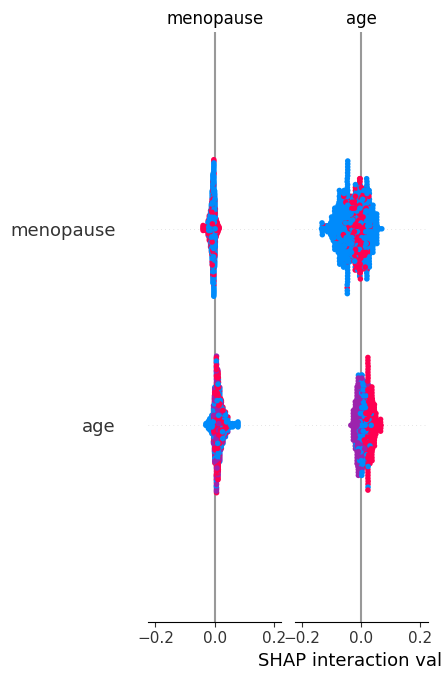


=== SHAP Dependence Plots (Top 5 by |mean SHAP|) ===


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Breast Cancer Metastasis — NA-aware vs Imputed on LSDS-5YDM
with Hyperparameter Sweep (RandomizedSearchCV + SHAP + PDP + PI)
All plots are DISPLAYED in cell output (NOT saved).
"""

import re, warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from scipy.stats import randint, uniform, loguniform

from xgboost import XGBClassifier
import shap

# ================================================
# CONFIG
# ================================================
DATA_PATH    = "LSDS-5YDM.xlsx"
TARGET_COL   = "metastasis"
TEST_SIZE    = 0.2
RANDOM_STATE = 42

KEEP_CODED_ONLY   = False
DROP_SOFT_LEAKAGE = False

NA_TOKENS   = {-999, "-999", "NA", "N/A", "Not applicable",
               "not applicable", "na", "Na"}
NA_SENTINEL = -999

# ================================================
# LOAD DATA
# ================================================
def read_any(path):
    ext = path.split(".")[-1].lower()
    if ext in ("xlsx", "xls"):
        sheets = pd.read_excel(path, sheet_name=None)
        df = sheets[next(iter(sheets))]
    else:
        df = pd.read_csv(path)
    df.columns = df.columns.astype(str).str.strip()
    return df

# ================================================
# ENCODING + NA MASKS
# ================================================
def to_numeric_df(Xdf):
    X = Xdf.copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    return X

def encode_features(X):
    X = X.copy()
    for c in X.columns:
        if not np.issubdtype(X[c].dtype, np.number):
            X[c] = X[c].astype("category").cat.add_categories(["__missing__"])
            X[c] = X[c].fillna("__missing__")
            X[c] = X[c].cat.codes
    return X

def build_na_masks(Xraw):
    str_df = Xraw.astype("string").apply(lambda s: s.str.strip().str.lower())

    # FIXED ERROR HERE (columns= not columns:)
    is_na_flag = pd.DataFrame(False, index=Xraw.index, columns=Xraw.columns)

    for tok in NA_TOKENS:
        if isinstance(tok, (int, float, np.integer, np.floating)):
            is_na_flag |= (Xraw == float(tok))
            is_na_flag |= (str_df == str(tok))
        else:
            is_na_flag |= (str_df == str(tok).strip().lower())

    Xnum = to_numeric_df(Xraw)
    is_missing = Xnum.isna() & (~is_na_flag)

    return Xnum, is_na_flag, is_missing

def _safe_median(s):
    s2 = s.dropna()
    return float(np.median(s2)) if len(s2) else 0.0

def make_na_aware(Xdf):
    Xraw = Xdf.copy()
    Xnum, naflag, miss = build_na_masks(Xraw)
    Xout = Xnum.copy()

    for c in Xout.columns:
        med = _safe_median(Xout.loc[~(naflag[c] | miss[c]), c])
        Xout.loc[miss[c], c] = med
        Xout.loc[naflag[c], c] = NA_SENTINEL
    return Xout

def make_imputed(Xdf):
    Xraw = Xdf.copy()
    Xnum, naflag, miss = build_na_masks(Xraw)
    Ximp = Xnum.copy()

    bad = naflag | miss
    for c in Ximp.columns:
        Ximp.loc[bad[c], c] = np.nan
        med = _safe_median(Ximp[c])
        Ximp[c] = Ximp[c].fillna(med)
    return Ximp

# ================================================
# HYPERPARAMETER SPACES
# ================================================
def make_spaces(spw):
    spaces = {}

    spaces["LogReg"] = dict(
        estimator=Pipeline([
            ("scaler", StandardScaler(with_mean=False)),
            ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
        ]),
        param_distributions={
            "clf__C": loguniform(1e-3, 1e3),
            "clf__penalty": ["l1","l2"],
        },
        n_iter=50
    )

    spaces["DecisionTree"] = dict(
        estimator=DecisionTreeClassifier(class_weight="balanced"),
        param_distributions={
            "max_depth": randint(2,30),
            "min_samples_split": randint(2,20),
            "min_samples_leaf": randint(1,10)
        },
        n_iter=50
    )

    spaces["RandomForest"] = dict(
        estimator=RandomForestClassifier(n_jobs=-1,class_weight="balanced"),
        param_distributions={
            "n_estimators": randint(200,1500),
            "max_depth": randint(2,30),
            "min_samples_split": randint(2,20),
            "min_samples_leaf": randint(1,10)
        },
        n_iter=50
    )

    spaces["KNN"] = dict(
        estimator=Pipeline([
            ("scaler", StandardScaler(with_mean=False)),
            ("clf", KNeighborsClassifier())
        ]),
        param_distributions={
            "clf__n_neighbors": randint(1,31),
            "clf__p": [1,2],
            "clf__weights":["uniform","distance"]
        },
        n_iter=50
    )

    spaces["XGBoost"] = dict(
        estimator=XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            random_state=42,
            n_jobs=-1,
            scale_pos_weight=spw
        ),
        param_distributions={
            "n_estimators": randint(200,2000),
            "max_depth": randint(2,8),
            "learning_rate": loguniform(1e-3,0.3),
            "subsample": uniform(0.6,0.4),
            "colsample_bytree": uniform(0.6,0.4),
        },
        n_iter=80
    )

    return spaces

# ================================================
# RANDOM SEARCH
# ================================================
def run_search(X, y, tag):
    pos = int((y==1).sum())
    neg = int((y==0).sum())
    spw = max(1.0, neg/max(1,pos))

    spaces = make_spaces(spw)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    rows=[]
    best={}

    print(f"\n===== {tag} : RandomizedSearchCV =====")

    for name, cfg in spaces.items():
        print(f"\n[{tag}] Searching {name} ...")

        rs = RandomizedSearchCV(
            estimator=cfg["estimator"],
            param_distributions=cfg["param_distributions"],
            n_iter=cfg["n_iter"],
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1,
            random_state=42,
            refit=True
        )
        rs.fit(X, y)

        rows.append({
            "Strategy":tag,
            "Model":name,
            "Best_AUC":rs.best_score_,
            "Best_Params":rs.best_params_
        })

        best[name] = rs.best_estimator_

        print(f"[{tag}] Best AUC={rs.best_score_:.3f}")

    summary = pd.DataFrame(rows).sort_values("Best_AUC",ascending=False)
    display(summary)
    return summary, best

# ================================================
# EVALUATION
# ================================================
def eval_best(best, X, y):
    rows=[]
    for name, clf in best.items():
        proba = clf.predict_proba(X)[:,1]
        pred  = (proba>=0.5).astype(int)

        rows.append({
            "Model":name,
            "AUC":roc_auc_score(y, proba),
            "Accuracy":accuracy_score(y,pred),
            "Precision":precision_score(y,pred,zero_division=0),
            "Recall":recall_score(y,pred,zero_division=0),
            "F1":f1_score(y,pred,zero_division=0)
        })
    return pd.DataFrame(rows)

# ================================================
# MAIN
# ================================================
def main():
    df = read_any(DATA_PATH)
    print("Loaded:", df.shape)

    # target
    y = df[TARGET_COL]
    if not np.issubdtype(y.dtype, np.number):
        y = (y.astype(str).str.lower().str.contains("yes")).astype(int)

    X_raw = df.drop(columns=[TARGET_COL])
    X_enc = encode_features(X_raw)

    # NA versions
    X_A = make_na_aware(X_enc)
    X_B = make_imputed(X_enc)

    # split
    idx_train, idx_test = train_test_split(
        np.arange(len(y)), test_size=TEST_SIZE,
        random_state=42, stratify=y
    )

    X_A_tr, X_A_te = X_A.iloc[idx_train], X_A.iloc[idx_test]
    X_B_tr, X_B_te = X_B.iloc[idx_train], X_B.iloc[idx_test]
    y_tr,   y_te   = y.iloc[idx_train],  y.iloc[idx_test]

    # Random search
    resA, bestA = run_search(X_A_tr, y_tr, "NA-aware")
    resB, bestB = run_search(X_B_tr, y_tr, "Imputed")

    # evaluation
    evalA = eval_best(bestA, X_A_te, y_te)
    evalB = eval_best(bestB, X_B_te, y_te)

    merged = evalA.merge(
        evalB,
        on="Model",
        suffixes=("_NA","_IM")
    )
    merged["ΔAUC"]=merged["AUC_IM"]-merged["AUC_NA"]
    display(merged)

    # ================================
    # SHAP + PI + PDP on BEST MODEL
    # ================================
    best_model_name = merged.sort_values("AUC_IM",ascending=False).iloc[0]["Model"]
    print(f"\n>>> Best model (Imputed) = {best_model_name}")

    final_model = bestB[best_model_name]

    # processed features (for SHAP)
    X_train_proc = X_B_tr.values
    X_test_proc  = X_B_te.values
    feature_names = X_B_tr.columns.tolist()

    # SHAP
    print("\n=== SHAP Summary ===")
    explainer = shap.TreeExplainer(final_model)
    shap_vals = explainer.shap_values(X_test_proc)

    shap.summary_plot(shap_vals, X_test_proc, feature_names=feature_names)

    # SHAP dependence (top features)
    print("\n=== SHAP Dependence Plots (Top 5 by |mean SHAP|) ===")
    mean_abs = np.abs(shap_vals).mean(axis=0)
    top5 = np.argsort(mean_abs)[-5:]

    for idx in top5:
        shap.dependence_plot(idx, shap_vals, X_test_proc, feature_names=feature_names)

    # SHAP force plot (first sample)
    print("\n=== SHAP Force Plot (Sample #0) ===")
    shap.initjs()
    display(shap.force_plot(explainer.expected_value, shap_vals[0,:], feature_names=feature_names))

    # Permutation Importance
    print("\n=== Permutation Importance ===")
    perm = permutation_importance(final_model, X_test_proc, y_te, n_repeats=40, random_state=42)
    pi_df = pd.DataFrame({
        "feature":feature_names,
        "importance":perm.importances_mean
    }).sort_values("importance",ascending=False)
    display(pi_df.head(10))

    # PDP
    print("\n=== Partial Dependence Plots (Top 5 Features) ===")
    for idx in top5:
        fig, ax = plt.subplots(figsize=(5,4))
        PartialDependenceDisplay.from_estimator(
            final_model, X_test_proc, [idx], feature_names=feature_names, ax=ax
        )
        plt.show()

# RUN
main()
